# **EDA Charged-Off Loans Data**

In [1]:
# Import packages & libraries 
import os
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from collections import Counter
import warnings
warnings.filterwarnings("ignore") 
pd.set_option('display.max_rows', None,'display.max_columns', None)

## 1. Introduction
<a id="intro"></a>
The objective is to use the loan data to build a model that can predict the loan status (whether or not a loan will be fully paid or charged off) and interpret the results to find the factors which affect the result. Such a predictive model could help LendingClub investors make better-informed investment decisions.

We want to develop a model that is **accurate** and **interpretable**.

This problem is a binary classification as I have only two classes to predict.

## 2. Data
<a id="importdata"></a>

In this project, we will work with the loan data.
The dataset is 1.8+ GB of size, including 2.2+ millions of loans from 2007 to 2017Q, each of which has 150+ associated features. 

In [2]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv.gz',compression='gzip',low_memory=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [4]:
df.sample(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
1809332,6836108,NaN,8000.0,8000.0,8000.0,36 months,10.64,260.55,B,B2,MetLife,3 years,MORTGAGE,57900.0,Not Verified,Aug-2013,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,121xx,NY,23.98,0.0,Apr-1998,720.0,724.0,1.0,NaN,NaN,17.0,0.0,11112.0,75.1,18.0,f,0.00,0.00,9379.714822,9379.71,8000.00,1379.71,0.0,0.0,0.0,Aug-2016,260.46,NaN,Mar-2019,644.0,640.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,246115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14800.0,NaN,NaN,NaN,7.0,14477.0,2388.0,82.3,0.0,0.0,31.0,187.0,71.0,12.0,1.0,71.0,NaN,0.0,NaN,0.0,4.0,4.0,4.0,5.0,11.0,5.0,6.0,4.0,17.0,0.0,0.0,0.0,1.0,100.0,50.0,0.0,0.0,267501.0,86641.0,13500.0,86066.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
451032,129754993,NaN,8000.0,8000.0,8000.0,36 months,6.71,245.96,A,A3,Sales,1 year,MORTGAGE,80000.0,Not Verified,Mar-2018,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,622xx,IL,15.35,0.0,Oct-2000,720.0,724.0,0.0,67.0,93.0,6.0,1.0,6147.0,58.5,16.0,f,5509.62,5509.62,2945.560000,2945.56,2490.38,455.18,0.0,0.0,0.0,Mar-2019,245.96,Apr-2019,Mar-2019,739.0,735.0,0.0,67.0,1.0,Individual,NaN,NaN,NaN,0.0,0.0,140363.0,0.0,3.0,0.0,1.0,14.0,15898.0,38.0,0.0,1.0,5100.0,42.0,10500.0,0.0,6.0,1.0,3.0,23394.0,900.0,85.0,0.0,0.0,209.0,182.0,22.0,14.0,3.0,61.0,NaN,5.0,NaN,1.0,1.0,2.0,1.0,3.0,9.0,2.0,4.0,2.0,6.0,0.0,0.0,0.0,0.0,93.8,100.0,1.0,0.0,174163.0,22045.0,6000.0,41504.0,NaN,NaN,

The dataset has numerical, categorical and missing values. Because there are so many features (150+), i will start the data engineering with dropping unnecessary features and then deal with the remaining features more in detail. 

## 3. Target Variable
<a id="targetvariable"></a>

We are trying to predict the loan_status column. Let's check the value distributions in this column first

In [5]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

We will try to distinguish 2 cases: loans being fully paid or charged off, assuming that they both meet the credit policy. 
We will only keep the rows with loan_status being "fully paid" or "charged off". 

In [6]:
df = df.loc[df['loan_status'].isin(['Fully Paid','Charged Off'])]

In [7]:
df['loan_status'].value_counts(normalize=False, dropna=False)

Fully Paid     1076751
Charged Off     268559
Name: loan_status, dtype: int64

In [8]:
df['loan_status'].value_counts(normalize=True, dropna=False)

Fully Paid     0.800374
Charged Off    0.199626
Name: loan_status, dtype: float64

About 80% (1M+) of the loans have been fully paid, and 20% (268k) have been charged off. Unbalanced data. We will try to handle this unbalance in the cross validation and need to pick appropriate metrics.

## 4. Feature Selection
<a id="featureselection"></a>

The raw data has 150 features, but not all of them are useful. 


We will drop the features with the following criteria:
- More than 50% of the data is missing
- The feature would not have been available at the time of the loan application ("issue_d"). 

We will also address the following:
- convert strings to numerical values
- drop superfluous attributes
- highly correlated predictors

### 4.1 Drop features missing too much data
<a id="missing_data"></a>

In [9]:
# Define a function to visulize the features with missing values, and % of total values, & datatype
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [10]:
missing_values_table(df)

Your selected dataframe has 151 columns.
There are 105 columns that have missing values.


,Missing Values,% of Total Values,type
member_id,1345310,100.0,float64
next_pymnt_d,1345310,100.0,object
orig_projected_additional_accrued_interest,1341551,99.7,float64
hardship_type,1339556,99.6,object
hardship_reason,1339556,99.6,object
hardship_status,1339556,99.6,object
deferral_term,1339556,99.6,float64
hardship_amount,1339556,99.6,float64
hardship_start_date,1339556,99.6,object
hardship_end_date,1339556,99.6,object


From this table, we can see that there is a huge gap between features missing some data (~15% and below) and those missing lots of data (up to 100%!). I chose 50% as the cutoff.

In [11]:
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.50].index)

In [12]:
print(drop_list)

['all_util', 'annual_inc_joint', 'debt_settlement_flag_date', 'deferral_term', 'desc', 'dti_joint', 'hardship_amount', 'hardship_dpd', 'hardship_end_date', 'hardship_last_payment_amount', 'hardship_length', 'hardship_loan_status', 'hardship_payoff_balance_amount', 'hardship_reason', 'hardship_start_date', 'hardship_status', 'hardship_type', 'il_util', 'inq_fi', 'inq_last_12m', 'max_bal_bc', 'member_id', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record', 'mths_since_rcnt_il', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'next_pymnt_d', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'orig_projected_additional_accrued_interest', 'payment_plan_start_date', 'revol_bal_joint', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_earliest_cr_line', 'sec_app_fico_range_high', 'sec_app_fico_range_low', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_mths_since_last_ma

In [13]:
len(drop_list)

58

In [14]:
def drop_cols(cols):
    df.drop(labels=cols, axis=1, inplace=True)

In [15]:
drop_cols(drop_list)

In [16]:
df.shape

(1345310, 93)

### 4.2 Remove unwated columns wrt business
<a id="cheat_data"></a>

The goal of this project is to predict whether a loan will be paid off BEFORE making the decision to lend the loan. Therefore, I would like to remove the features that were unavailable before lending a loan.  

In [17]:
print(sorted(df.columns))

['acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sa

After checking the definition of these features, I will drop the ones that would have not been available beforeloan was lend. 

In [18]:
drop_list = ['acc_now_delinq', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'funded_amnt', 'funded_amnt_inv', 'hardship_flag', 'inq_last_6mths', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',  'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pymnt_plan', 'recoveries', 'tax_liens', 'tot_coll_amt', 'tot_cur_bal', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 'total_il_high_credit_limit', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp', 'total_rev_hi_lim']


In [19]:
drop_cols(drop_list)

In [20]:
print(sorted(df.columns))

['addr_state', 'annual_inc', 'application_type', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 'issue_d', 'loan_amnt', 'loan_status', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc', 'open_acc', 'policy_code', 'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 'url', 'verification_status', 'zip_code']


In [21]:
len(df.columns)

35

### 4.3 Inspect the remaining features one by one
<a id="inspect"></a>

Now we are left with reasonable number of features (34), I will screen each feature and decide if a feature should be dropped. 

The tasks involved are:
- Visualization with count distributions, bar plot & KDE plot with faceting on the loan status
- Drop useless features (e.g., "id")
- Cleaning & Formatting (e.g., ["emp_length"](#emp_length), ["earliest_cr_line"](#earliest_cr_line))
- Transformation of features (e.g., log transformation of ["annual_inc"](#annual_inc), average of ["fico_score"](#fico))
- Pick the most relevant features in the data (e.g., "sub_grade" vs "grade", "zip_code" vs "addr_state")

In [22]:
# make general plots to examine each feature
def plot_var(col_name, full_name, continuous):
    """
    Visualize a variable with/without faceting on the loan status.
    - col_name is the variable name in the dataframe
    - full_name is the full variable name
    - continuous is True for continuous variables
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=False, figsize=(15,3))
    # plot1: counts distribution of the variable
    
    if continuous:  
        sns.distplot(df.loc[df[col_name].notnull(), col_name], kde=False, ax=ax1)
    else:
        sns.countplot(df[col_name], order=sorted(df[col_name].unique()), color='#5975A4', saturation=1, ax=ax1)
    ax1.set_xlabel(full_name)
    ax1.set_ylabel('Count')
    ax1.set_title(full_name)

          
    # plot2: bar plot of the variable grouped by loan_status
    if continuous:
        sns.boxplot(x=col_name, y='loan_status', data=df, ax=ax2)
        ax2.set_ylabel('')
        ax2.set_title(full_name + ' by Loan Status')
    else:
        Charged_Off_rates = df.groupby(col_name)['loan_status'].value_counts(normalize=True)[:,'Charged Off']
        sns.barplot(x=Charged_Off_rates.index, y=Charged_Off_rates.values, color='#5975A4', saturation=1, ax=ax2)
        ax2.set_ylabel('Fraction of Loans Charged Off')
        ax2.set_title('Charged Off Rate by ' + full_name)
        ax2.set_xlabel(full_name)
    
    # plot3: kde Kernel Distribution plot of the variable gropued by loan_status
    if continuous:  
        facet = sns.FacetGrid(df, hue = 'loan_status', size=3, aspect=4)
        facet.map(sns.kdeplot, col_name, shade=True)
        #facet.set(xlim=(df[col_name].min(), df[col_name].max()))
        facet.add_legend()  
    else:
        fig = plt.figure(figsize=(12,3))
        sns.countplot(x=col_name, hue='loan_status', data=df, order=sorted(df[col_name].unique()) )
     
    plt.tight_layout()


### issue_d
Data Dictionary: "The month which the loan was funded.

Because we are only using the variables that are available before the loan was funded to make predictions, issue_d will not be included in modeling. This feature is kept here for train/test sample split, after which this feature will be dropped. 

### id
Data Dictionary: "A unique assigned ID for the loan listing."

In [23]:
df['id'].sample(5)

2220173    92381366
1174416    29884762
1348412    10152981
1195254    27019966
81908      63329869
Name: id, dtype: object

In [24]:
len(df['id'].unique())

1345310

"id" is a unique index. It's not useful as a categorical variable (so many unique values), nor as a numerical variable (a wild range of its values). Therefore I will drop this feature. 

In [25]:
drop_cols('id')

### loan_amnt
Data Dictionary: "The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value."

In [26]:
df['loan_amnt'].describe()

count    1.345310e+06
mean     1.441997e+04
std      8.717051e+03
min      5.000000e+02
25%      8.000000e+03
50%      1.200000e+04
75%      2.000000e+04
max      4.000000e+04
Name: loan_amnt, dtype: float64

"loan_amnt" ranges from \$0.5 k to \$40 k, with a median of 12k. 

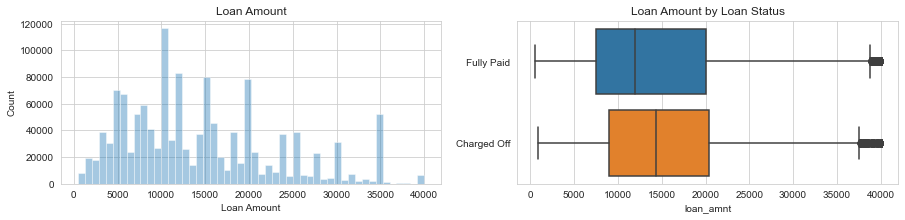

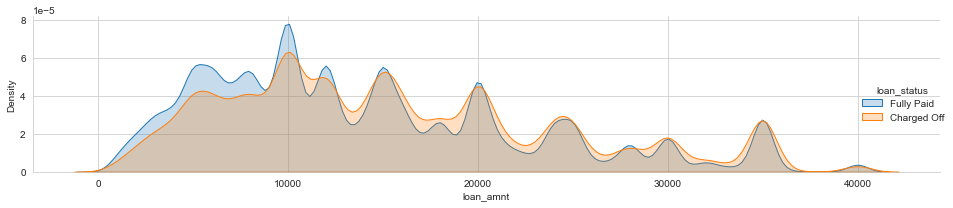

In [27]:
plot_var('loan_amnt', 'Loan Amount', continuous=True)

"Charged off" loans seem to have higher loan amount. I will further examine the statistical difference in the later analysis.

### term
Data Dictionary: "The number of payments on the loan. Values are in months and can be either 36 or 60."

In [28]:
df['term'].sample(5)

1903759     36 months
1217949     60 months
1330047     36 months
1798714     36 months
1633252     36 months
Name: term, dtype: object

In [29]:
df['term'].value_counts(dropna=False)

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

In [30]:
df['term'] = df['term'].apply(lambda s: np.int8(s.split()[0]))

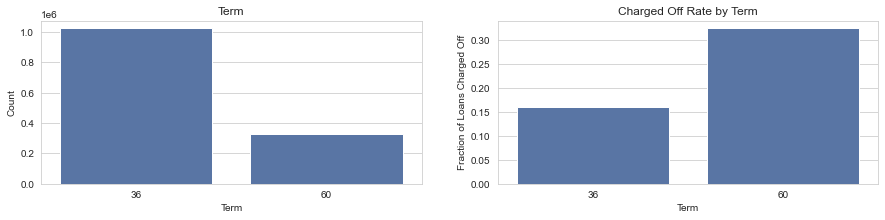

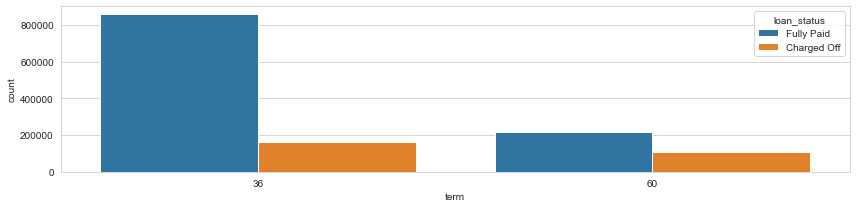

In [31]:
plot_var('term', 'Term', continuous=False)

In [32]:
df['term'].value_counts(normalize=True)

36    0.758742
60    0.241258
Name: term, dtype: float64

About 76% of the loans are 36 months and the rest are 60 months. The latter tends to have lower fraction of being fully paid.

Compare the charge-off rate by loan period

In [33]:
df.groupby('term')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

term
36    0.159934
60    0.324454
Name: loan_status, dtype: float64

17% of the 36-month loans are charge off, while 33% of the 60-month are charged off. Longer term leads to higher charged off? This feature should be useful in modeling.

### int_rate
Data Dictionary: "Interest Rate on the loan."

In [34]:
df['int_rate'].describe()

count    1.345310e+06
mean     1.323962e+01
std      4.768716e+00
min      5.310000e+00
25%      9.750000e+00
50%      1.274000e+01
75%      1.599000e+01
max      3.099000e+01
Name: int_rate, dtype: float64

The interest rage ranges from 5% to 31%, with a median at 13%. 

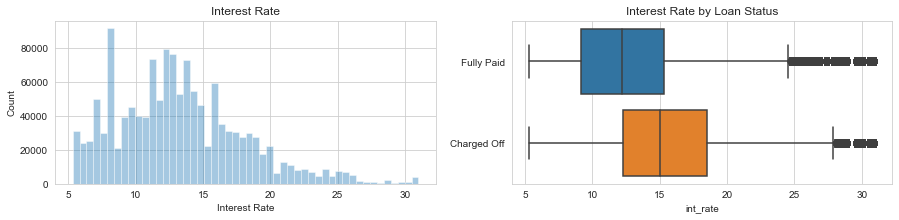

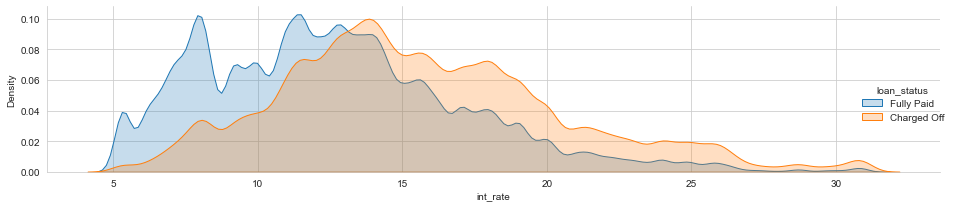

In [35]:
plot_var('int_rate', 'Interest Rate', continuous=True)

The higher the interest rate is, the more likely for being charged off. 
There are some outliers in the Fully Paid dataset. Let's take a look at them, as outliers may distort ML analysis. 

### Outliers
- outliers can be exactly what we want to learn about, e.g., anomaly detection. 
- In this project, however, outliers may distort the picture of the data in both statistical analysis and visualization. 
- Below, I use the modified Z-score method and the IQR method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

drop_list = df.select_dtypes(exclude=['object']).columns

In [36]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

#Outliers_to_drop_z_score = outliers_modified_z_score(df,2,['loan_amnt', 'term', 'int_rate', 'installment', 'annual_inc', 'dti','fico_range_high', 'pub_rec', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc','earliest_cr_line_'])

In [37]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)
      
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers

In [38]:
df.groupby('loan_status')['int_rate'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,15.710714,4.910387,5.31,12.29,15.05,18.55,30.99
Fully Paid,1076751.0,12.623288,4.527227,5.31,9.17,12.23,15.31,30.99


Any values > 75% percentile (18.5 for "charged off", 15.61 for "Fully Paid") are defined as outliers. 

In [39]:
#df.groupby('loan_status')['int_rate'].value_counts()['Fully Paid'].sort_index()

In [40]:
df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0]

234329

In [41]:
(df.loc[(df.int_rate > 15.61) & (df.loan_status == 'Fully Paid')].shape[0])/df['loan_status'].value_counts(normalize=False, dropna=False)[0]

0.21762598780962358

In [42]:
df.loc[(df.int_rate >18.55) & (df.loan_status == 'Charged Off')].shape[0]/df['loan_status'].value_counts(normalize=False, dropna=False)[1]

0.245521468280713

The percentage of outliers is roughly the same for the Fully Paid/Charged off data, ~23%. A bit too much to be dropped. I will keep these outliers for now.

### installment
Data Dictionary: "The monthly payment owed by the borrower if the loan originates."

In [43]:
df['installment'].describe()

count    1.345310e+06
mean     4.380755e+02
std      2.615126e+02
min      4.930000e+00
25%      2.484800e+02
50%      3.754300e+02
75%      5.807300e+02
max      1.719830e+03
Name: installment, dtype: float64

Installments range from \$5  to \$1715, with a median at \$377. 

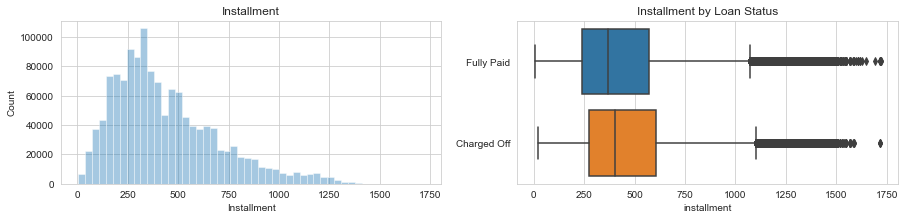

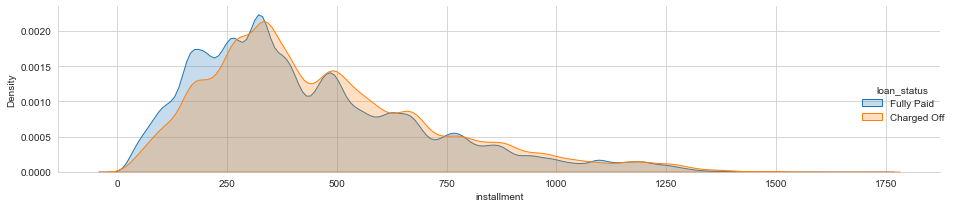

In [44]:
plot_var('installment', 'Installment', continuous=True)

Charged-off loans tend to have higher installments but the difference of the mean values is very small (460 vs 431). Later, we will do a KS test to see if there are any statistical difference of "installment" between Fully Paid/charged off. 

In [45]:
df.groupby('loan_status')['installment'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,465.147994,262.774106,21.62,275.29,402.83,605.31,1717.63
Fully Paid,1076751.0,431.323226,260.759563,4.93,240.92,368.26,573.06,1719.83


### grade, sub_grade
Data Dictionary for grade: "assigned loan grade."
Data Dictionary for sub_grade: "LC assigned loan subgrade."

What are the possible values of grade and sub_grade?

In [46]:
sorted(df['grade'].unique())

['A', 'B', 'C', 'D', 'E', 'F', 'G']

In [47]:
print(sorted(df['sub_grade'].unique()))

['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2', 'C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5']


The "grade" is included in the "sub_grade" column, so it could be dropped.

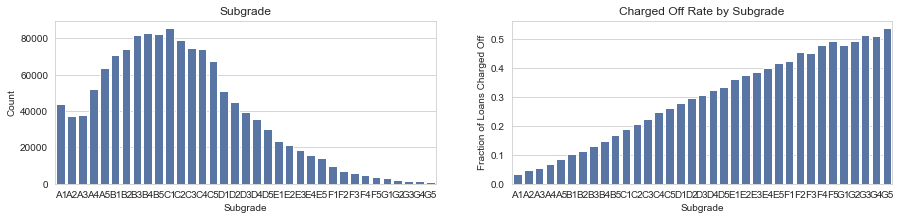

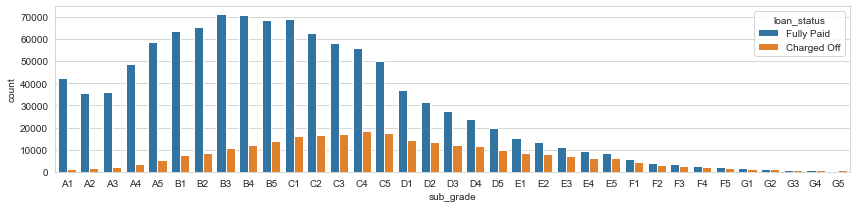

In [48]:
plot_var('sub_grade','Subgrade',continuous=False)

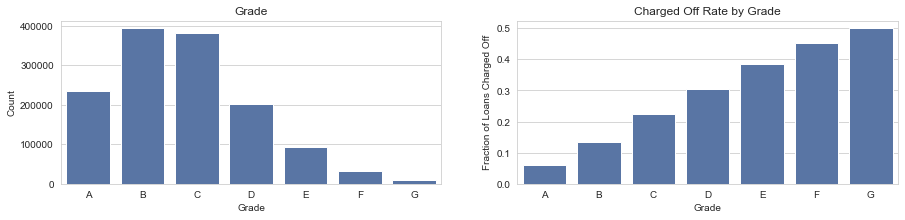

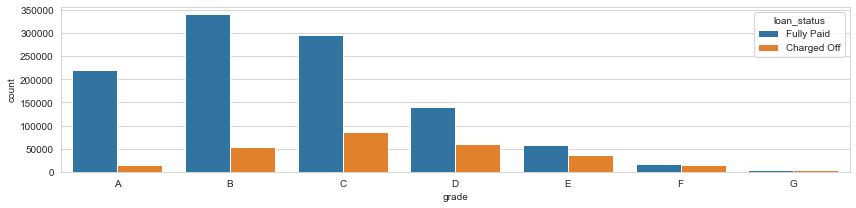

In [49]:
plot_var('grade','Grade',continuous=False)

There is a trend of higher fraction of loans Charged off as the grade going from A to G, with some small variations among subgrades. 

In [50]:
#df.drop(labels='grade',axis=1,inplace=True)
drop_cols('grade')

### emp_title
Data Dictionary: "The job title supplied by the Borrower when applying for the loan."

In [51]:
df['emp_title'].describe()

count     1259525
unique     378353
top       Teacher
freq        21268
Name: emp_title, dtype: object

There are too many unique titles for this feature to be useful, so we drop this feature. 

In [52]:
df['emp_title'].sample(5)

156441     Director of Client Solutions
304866              Materiel specialist
1262225    Clinical Practice Pharmacist
399194       Executive Sales Specialist
1680615                  Office Manager
Name: emp_title, dtype: object

In [53]:
drop_cols('emp_title')

### emp_length
<a id="emp_length"></a>
Data Dictionary: "Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years." The actual data does not match this description:

In [54]:
df['emp_length'].value_counts(dropna=False).sort_index()

1 year        88494
10+ years    442199
2 years      121743
3 years      107597
4 years       80556
5 years       84154
6 years       62733
7 years       59624
8 years       60701
9 years       50937
< 1 year     108061
NaN           78511
Name: emp_length, dtype: int64

There are 42k loans without the information on emp_length. Convert this feature to integers. 

In [55]:
df['emp_length'].replace('10+ years', '10 years', inplace=True)

In [56]:
df['emp_length'].replace('< 1 year', '0 years', inplace=True)

In [57]:
df['emp_length'].value_counts(dropna=False).sort_index()

0 years     108061
1 year       88494
10 years    442199
2 years     121743
3 years     107597
4 years      80556
5 years      84154
6 years      62733
7 years      59624
8 years      60701
9 years      50937
NaN          78511
Name: emp_length, dtype: int64

0 year ----> 0        year -----> extracting value 0

In [59]:
df.emp_length.map( lambda x: str(x).split()[0]).value_counts(dropna=True).sort_index()

0      108061
1       88494
10     442199
2      121743
3      107597
4       80556
5       84154
6       62733
7       59624
8       60701
9       50937
nan     78511
Name: emp_length, dtype: int64

In [60]:
df['emp_length'] = df.emp_length.map( lambda x: float(str(x).split()[0]))

In [61]:
df['emp_length'].sample(5)

1196811    3.0
413746     9.0
149849     2.0
2025820    2.0
1823703    0.0
Name: emp_length, dtype: float64

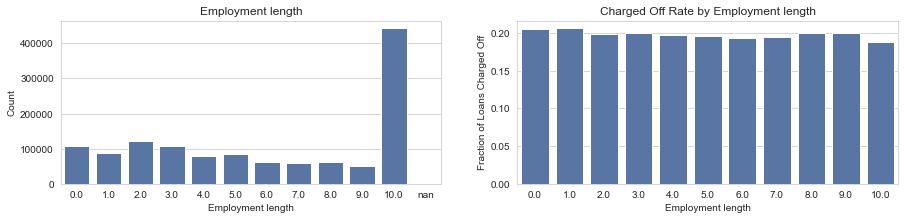

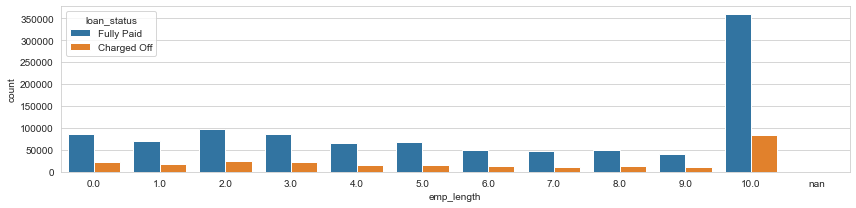

In [62]:
plot_var('emp_length', 'Employment length', continuous=False)

One third of the loans go to the people with longer than 10 years of employments. However, the fully paid rate seems not quite related to this feature. Again, this will be further examined in a statistical test at the end. 

### home_ownership
Data Dictionary: "The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER."

a legal agreement by which a bank, building society, etc. lends money at interest in exchange for taking title of the debtor's property, with the condition that the conveyance of title becomes void upon the payment of the debt.

In [63]:
df['home_ownership'].value_counts()

MORTGAGE    665579
RENT        534421
OWN         144832
ANY            286
OTHER          144
NONE            48
Name: home_ownership, dtype: int64

Replace "ANY" & "None" with "OTHER". 

In [64]:
df['home_ownership'].replace(['NONE','ANY'],'OTHER', inplace=True)

In [65]:
df['home_ownership'].value_counts()

MORTGAGE    665579
RENT        534421
OWN         144832
OTHER          478
Name: home_ownership, dtype: int64

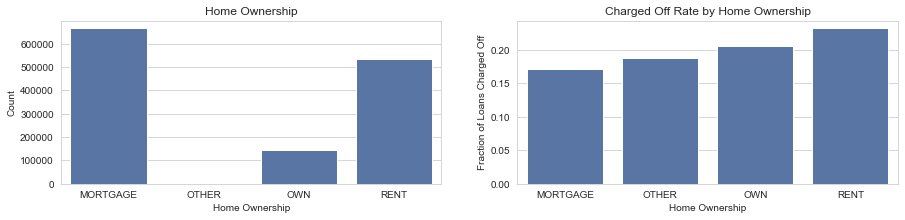

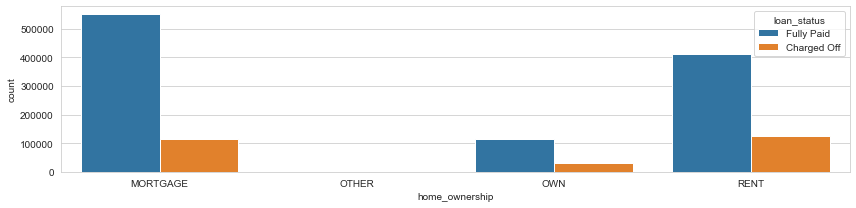

In [66]:
plot_var('home_ownership', 'Home Ownership', continuous=False)

In [67]:
df.groupby('home_ownership')['loan_status'].value_counts(normalize=True).loc[:,'Charged Off']

home_ownership
MORTGAGE    0.172077
OTHER       0.188285
OWN         0.206198
RENT        0.232165
Name: loan_status, dtype: float64

There appear to be small differences in charge-off rates by home ownership status. Mortgage & OTHER has slightly less probability of Charged-Off. Because of the large numbers of observations in each category, these differences might be statistically significant.

### annual_inc
<a id="annual_inc"></a>
Data Dictionary: "The self-reported annual income provided by the borrower during registration."

In [68]:
df['annual_inc'].describe()

count    1.345310e+06
mean     7.624764e+04
std      6.992510e+04
min      0.000000e+00
25%      4.578000e+04
50%      6.500000e+04
75%      9.000000e+04
max      1.099920e+07
Name: annual_inc, dtype: float64

Annual income ranges from \$0 to \$8M, with a median at \$65k, which doubles the national median individual income in the US (\$40k for males and \$25k for females). Due to the large range of variation, we log-transform the values.

In [69]:
df['annual_inc'] = df['annual_inc'].apply(lambda x:np.log10(x+1))

In [70]:
df['annual_inc'].describe()

count    1.345310e+06
mean     4.812814e+00
std      2.477200e-01
min      0.000000e+00
25%      4.660685e+00
50%      4.812920e+00
75%      4.954247e+00
max      7.041361e+00
Name: annual_inc, dtype: float64

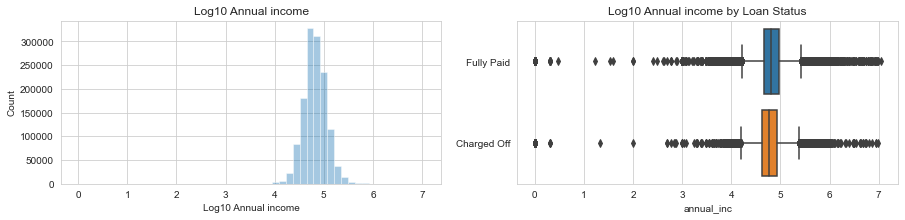

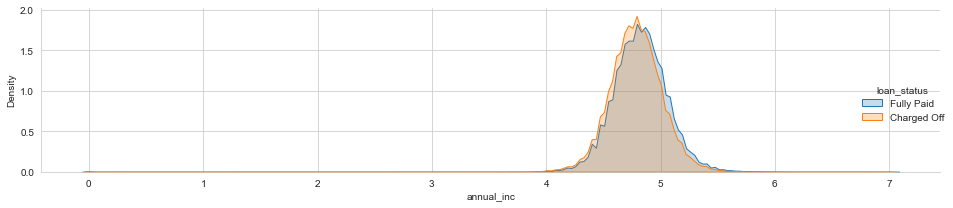

In [71]:
plot_var('annual_inc', 'Log10 Annual income', continuous=True)

Let's look closer of the difference here

In [72]:
df.groupby('loan_status')['annual_inc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,4.781756,0.241984,0.0,4.633479,4.778158,4.929424,6.977724
Fully Paid,1076751.0,4.820560,0.248526,0.0,4.672107,4.812920,4.968488,7.041361


For both cases, there are quite a few outliers (in the lower end). 

### verication_status
Data Dictionary: "Indicates if income was verified by [Lending Club], not verified, or if the income source was verified."

In [73]:
df['verification_status'].value_counts()

Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

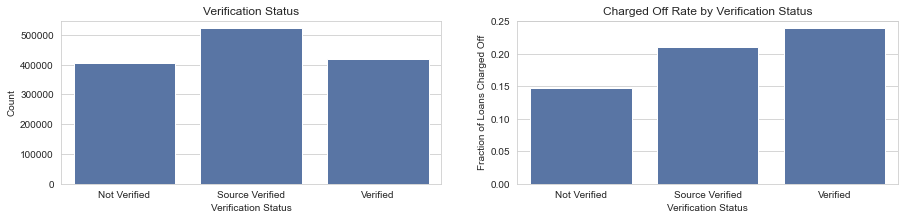

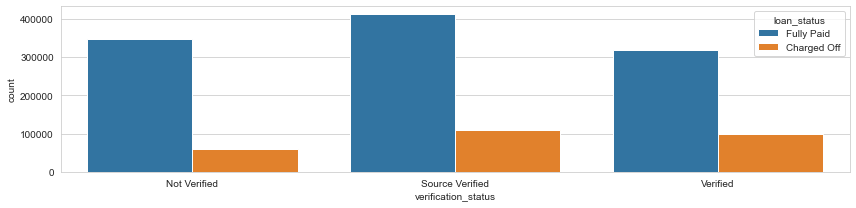

In [74]:
plot_var('verification_status', 'Verification Status', continuous=False)

Surprisingly, verified loans have higher chance of being charged-Off. I would guess the opposite way.

### purpose
Data Dictionary: "A category provided by the borrower for the loan request."

In [75]:
df['purpose'].value_counts()

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
medical                15554
small_business         15416
car                    14585
moving                  9480
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, dtype: int64

Now let's check the charged-off rates of purposes.

In [76]:
df.groupby('purpose')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

purpose
small_business        0.297094
renewable_energy      0.236870
moving                0.233544
house                 0.218806
medical               0.217757
debt_consolidation    0.211469
other                 0.210401
vacation              0.191726
major_purchase        0.185998
home_improvement      0.177158
educational           0.171779
credit_card           0.169270
car                   0.146795
wedding               0.121622
Name: loan_status, dtype: float64

We see that, 30% of the loans for small_business are charged off, but only 12% of wedding are charged Off.

### title
Data Dictionary: "The loan title provided by the borrower."

In [77]:
df['title'].describe()

count                1328651
unique                 61682
top       Debt consolidation
freq                  660960
Name: title, dtype: object

In [78]:
df['title'].value_counts().head(10)

Debt consolidation         660960
Credit card refinancing    249910
Home improvement            75073
Other                       66778
Major purchase              24045
Debt Consolidation          15695
Medical expenses            13576
Business                    11750
Car financing               11220
Vacation                     8046
Name: title, dtype: int64

There are 12 unique purposes in the dataset, and from the top 10 titles, it seems that this information is covered in the "purpose". So we drop this column. 

In [79]:
drop_cols('title')

### zip_code, addr_stat
Data Dictionary for zip_code: "The first 3 numbers of the zip code provided by the borrower in the loan application."  
Data Dictionary for addr_state: "The state provided by the borrower in the loan application."  

In [80]:
df['zip_code'].describe()

count     1345309
unique        943
top         945xx
freq        15005
Name: zip_code, dtype: object

In [81]:
df['addr_state'].describe()

count     1345310
unique         51
top            CA
freq       196528
Name: addr_state, dtype: object

There are many unique "zip_code" values, and the zip_code info should be equivalent to "addr_stat". Therefore we drop the "zip_code". 

In [82]:
drop_cols('zip_code')

In [83]:
df.groupby('addr_state')['loan_status'].value_counts(normalize=True)[:,'Charged Off'].sort_values(ascending=False)

addr_state
MS    0.260777
NE    0.251813
AR    0.240868
AL    0.236321
OK    0.234753
LA    0.231821
NY    0.220435
NV    0.219223
FL    0.214746
IN    0.214082
TN    0.214079
NM    0.213665
SD    0.213227
MD    0.213085
MO    0.212935
NJ    0.211212
KY    0.209829
PA    0.207921
NC    0.207839
OH    0.205283
ND    0.204744
MI    0.202957
HI    0.202013
VA    0.199422
TX    0.198223
DE    0.197462
MN    0.197430
AK    0.196552
AZ    0.196299
CA    0.196104
MA    0.190528
ID    0.188277
GA    0.183927
WI    0.183510
IL    0.180974
RI    0.178675
CT    0.173763
UT    0.170586
MT    0.168716
WY    0.167693
KS    0.167438
SC    0.162769
WA    0.157565
CO    0.155269
WV    0.155187
NH    0.145759
OR    0.143850
IA    0.142857
VT    0.139517
ME    0.138424
DC    0.132086
Name: loan_status, dtype: float64

MS has the highest fraction of Charged Off (0.28), whereas DC has the lowest fraction at 0.13. 

### dti
Data Dictionary: "A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income."

In [84]:
df['dti'].describe()

count    1.344936e+06
mean     1.828267e+01
std      1.116045e+01
min     -1.000000e+00
25%      1.179000e+01
50%      1.761000e+01
75%      2.406000e+01
max      9.990000e+02
Name: dti, dtype: float64

The values of -1 or 999 are probably outliers. Let's look at its histogram .

Text(0.5, 1.0, 'DTI by loan status')

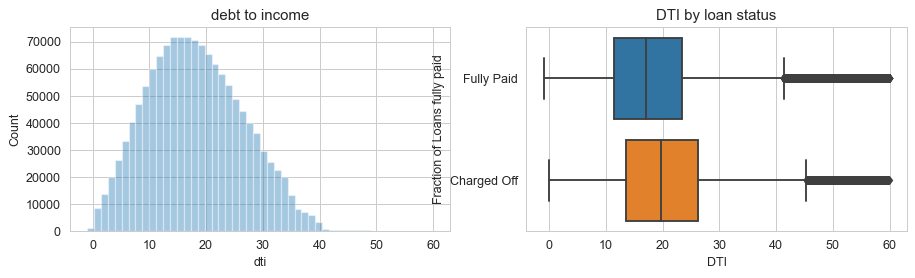

In [85]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,3), dpi=90)
sns.distplot(df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], kde=False, ax=ax1)
ax1.set_xlabel('dti')
ax1.set_ylabel('Count')
ax1.set_title('debt to income')
sns.boxplot(x=df.loc[df['dti'].notnull() & (df['dti'] < 60), 'dti'], y='loan_status', data=df, ax=ax2)
ax2.set_xlabel('DTI')
ax2.set_ylabel('Fraction of Loans fully paid')
ax2.set_title('Fully paid rate by debt to income')
ax2.set_title('DTI by loan status')

In [86]:
(df['dti'] > 40).sum() / (df['dti']).sum()

0.0002751635018498183

In [87]:
(df['dti'] > 40).sum()

6766

Very few (0.01%) outliers with dti > 60. 
From the figure it seems that the Charged Off loans have higher DTI. Let's check. 

In [88]:
df.groupby('loan_status')['dti'].median()

loan_status
Charged Off    19.76
Fully Paid     17.11
Name: dti, dtype: float64

It's clear that borrowers who have higher DTI are more likely to be charged off 

### open_acc
Data Dictionary: "The number of open credit lines in the borrower's credit file."

In [89]:
df['open_acc'].describe()

count    1.345310e+06
mean     1.159352e+01
std      5.473789e+00
min      0.000000e+00
25%      8.000000e+00
50%      1.100000e+01
75%      1.400000e+01
max      9.000000e+01
Name: open_acc, dtype: float64

In [90]:
#plt.figure(figsize=(10,3), dpi=90)
#sns.countplot(df['open_acc'], order=sorted(df['open_acc'].unique()),saturation=1)
#_, _ = plt.xticks(np.arange(0, 90, 5), np.arange(0, 90, 5))
#plt.title('Number of Open Credit Lines')

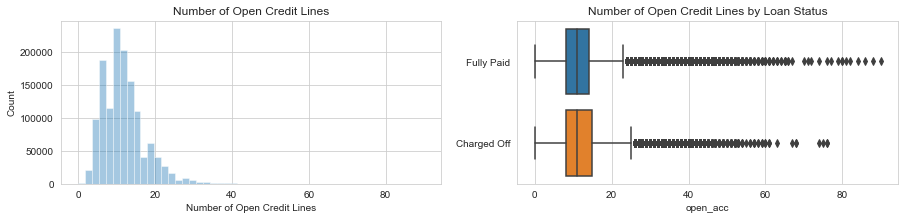

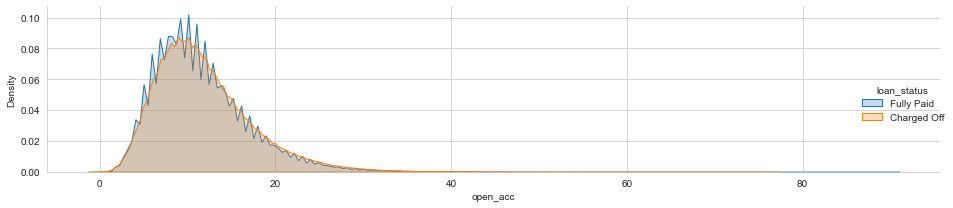

In [91]:
plot_var('open_acc', 'Number of Open Credit Lines', continuous=True)

There seems no significant difference in number of credit lines between fully paid loans and charged-off loans.

In [92]:
df.groupby('loan_status')['open_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268559.0,11.901269,5.637964,0.0,8.0,11.0,15.0,76.0
Fully Paid,1076751.0,11.516763,5.429354,0.0,8.0,11.0,14.0,90.0


### fico_range_low, fico_range_high
<a id="fico"></a>
Data Dictionary for fico_range_low: "The lower boundary range the borrower’s FICO at loan origination belongs to."  
Data Dictionary for fico_range_high: "The upper boundary range the borrower’s FICO at loan origination belongs to."


In [93]:
df[['fico_range_low','fico_range_high']].describe()

,fico_range_low,fico_range_high
count,1.345310e+06,1.345310e+06
mean,6.961850e+02,7.001852e+02
std,3.185251e+01,3.185316e+01
min,6.250000e+02,6.290000e+02
25%,6.700000e+02,6.740000e+02
50%,6.900000e+02,6.940000e+02
75%,7.100000e+02,7.140000e+02
max,8.450000e+02,8.500000e+02


Check the correlation between the two:

In [94]:
df[['fico_range_low','fico_range_high']].corr()

,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


These two are highly correlated, therefore we only need to keep one. We create a new feature, "fico_score" which is the mean value of the "fico_range_low" and "fico_range_high"

In [95]:
df['fico_score'] = (df['fico_range_low'] + df['fico_range_high'])/2.

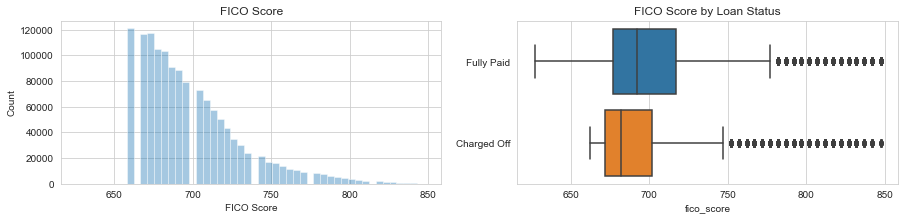

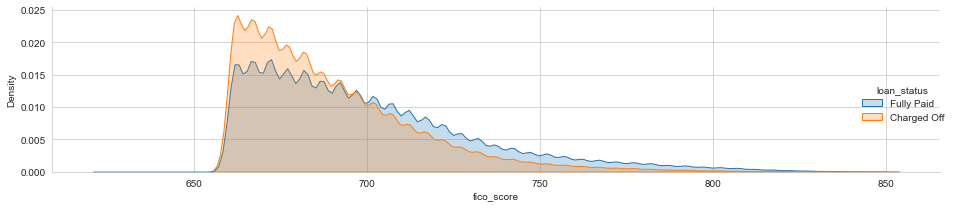

In [96]:
plot_var('fico_score', 'FICO Score', continuous=True)

There is noticeable difference in FICO scores between fully paid and charged-off loans.

**Thought 1:** A side note, what are the missing values in the specific FICO scores (i.e., ~620, 700, 730)? where are they from?

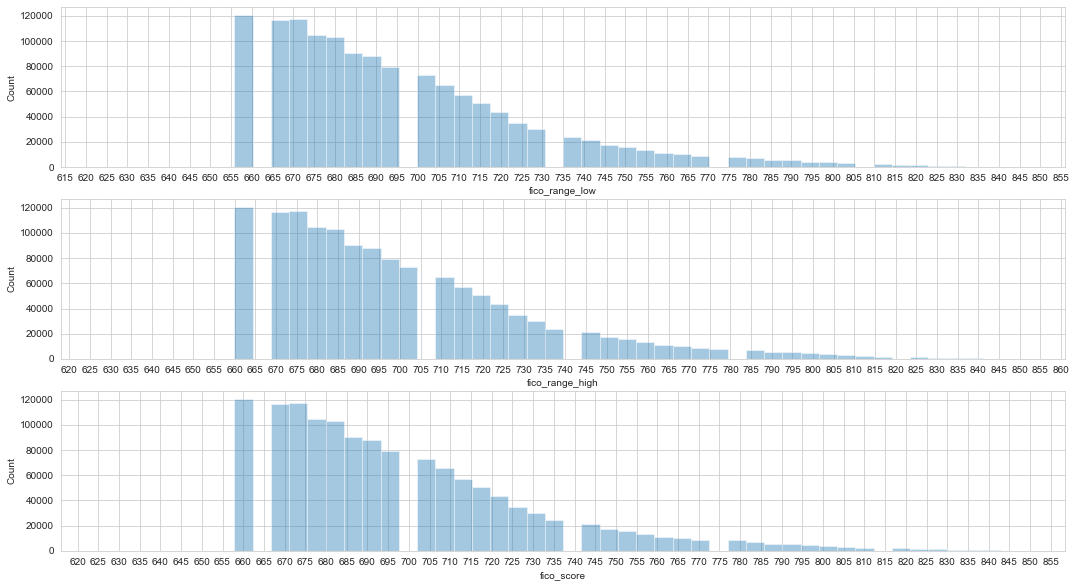

In [97]:
import matplotlib.ticker as ticker

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=False, figsize=(18,10))
sns.distplot(df.loc[df['fico_range_low'].notnull(), 'fico_range_low'], kde=False, ax=ax1)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax1.set_ylabel('Count')

sns.distplot(df.loc[df['fico_range_high'].notnull(), 'fico_range_high'], kde=False, ax=ax2)
ax2.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax2.set_ylabel('Count')

sns.distplot(df.loc[df['fico_score'].notnull(), 'fico_score'], kde=False, ax=ax3)
ax3.set_ylabel('Count')
ax3.xaxis.set_major_locator(ticker.MultipleLocator(5))

In [98]:
df['fico_range_low'].value_counts().sort_index().head(5)

625.0         1
630.0         1
660.0    120862
665.0    116821
670.0    117202
Name: fico_range_low, dtype: int64

In [99]:
df['fico_range_high'].value_counts().sort_index().head(5)

629.0         1
634.0         1
664.0    120862
669.0    116821
674.0    117202
Name: fico_range_high, dtype: int64

In [100]:
df['fico_score'].value_counts().sort_index().head(5)

627.0         1
632.0         1
662.0    120862
667.0    116821
672.0    117202
Name: fico_score, dtype: int64

**Thought 3:** As I know that FICO score is a very important feature, I would like to check the correlations between FICO score, int_rate and the term, 3 of the most important features that show different distributions between "Charged-off" and "fully paid" loans from previous EDA.

In [101]:
df[['fico_score','int_rate','term']].corr()

,fico_score,int_rate,term
fico_score,1.000000,-0.405365,-0.002222
int_rate,-0.405365,1.000000,0.417230
term,-0.002222,0.417230,1.000000


It seems that the higher the fico_score is, the lower the int_rate. Let's take a look at their correlations.

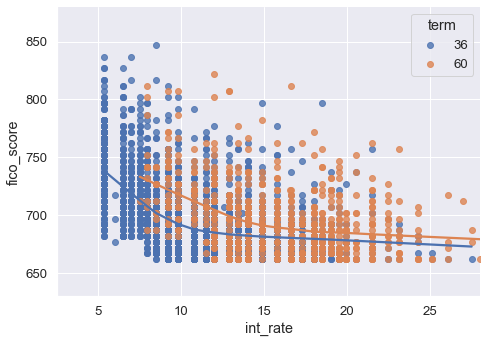

In [102]:
plot_df = df.query('fico_score > 650 & int_rate <28')[:3000]

sns.set(font_scale=1.2, rc={"lines.linewidth": 1.5}) 

g = sns.lmplot("int_rate", "fico_score", data=plot_df, hue='term',lowess=True, size=5,aspect=1.4, legend_out=False)

g.set(xlim=(2.5, 28),ylim=(630, 880),alpha = .5)

#g.savefig('1.png',transparent=True)

short-term loans have higher "fico_score" especially at lower "int_rate". I will explore the correlations between variables in the later analysis.

In [103]:
drop_cols(['fico_range_high','fico_range_low'])

### pub_rec_bankruptcies
Data Dictionary: "Number of public record bankruptcies."

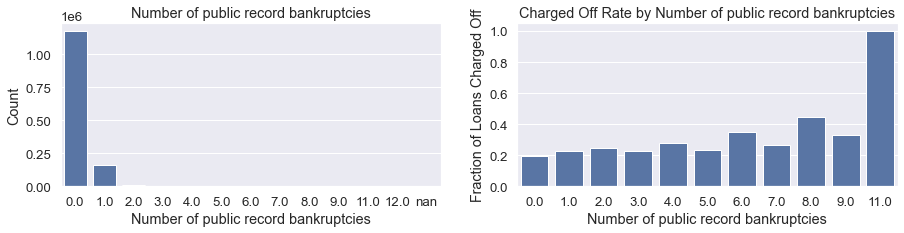

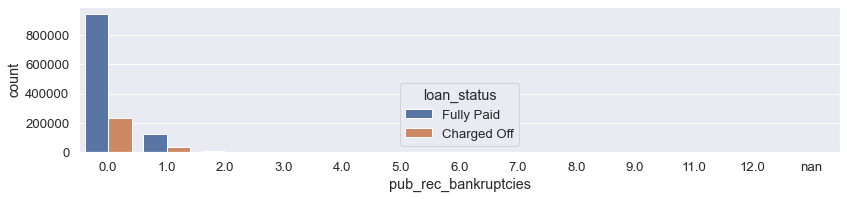

In [104]:
plot_var('pub_rec_bankruptcies', 'Number of public record bankruptcies', continuous=False)

In [105]:
df[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.649637
pub_rec_bankruptcies,0.649637,1.000000


"pub_rec" and "pub_rec_bankruptcies" are highly correlated. could only feed one of them into the modeling.

### revol_bal
Data Dictionary: "Total credit revolving balance."

In [106]:
df['revol_bal'].describe()

count    1.345310e+06
mean     1.624811e+04
std      2.232817e+04
min      0.000000e+00
25%      5.943000e+03
50%      1.113400e+04
75%      1.975575e+04
max      2.904836e+06
Name: revol_bal, dtype: float64

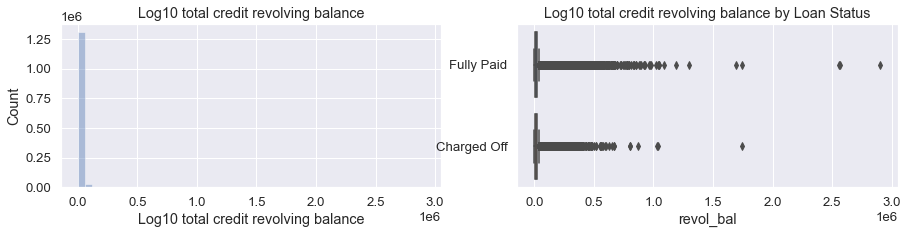

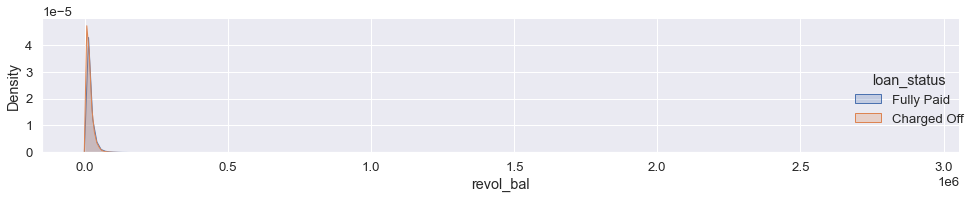

In [107]:
plot_var('revol_bal', 'Log10 total credit revolving balance', continuous=True)

In [108]:
df['revol_bal'] = df['revol_bal'].apply(lambda x:np.log10(x+1))

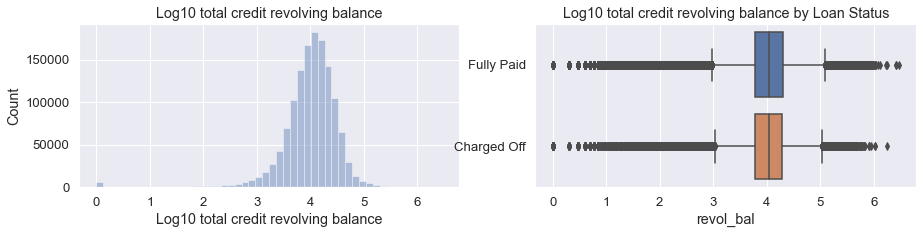

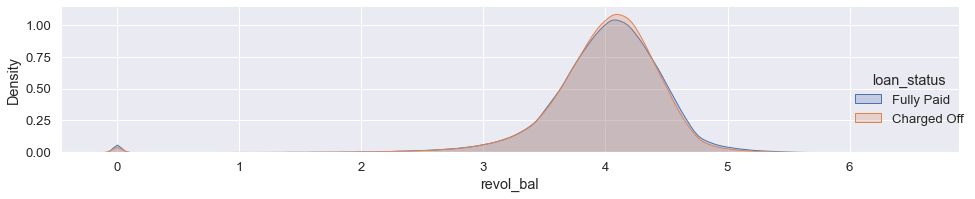

In [109]:
plot_var('revol_bal', 'Log10 total credit revolving balance', continuous=True)

### revol_util
Data Dictionary: "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit."

In [110]:
df['revol_util'].describe()

count    1.344453e+06
mean     5.181002e+01
std      2.452107e+01
min      0.000000e+00
25%      3.340000e+01
50%      5.220000e+01
75%      7.070000e+01
max      8.923000e+02
Name: revol_util, dtype: float64

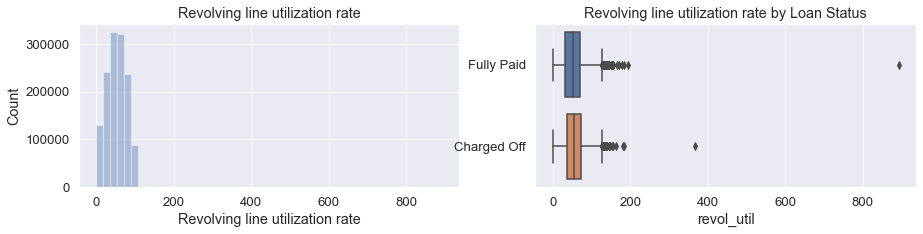

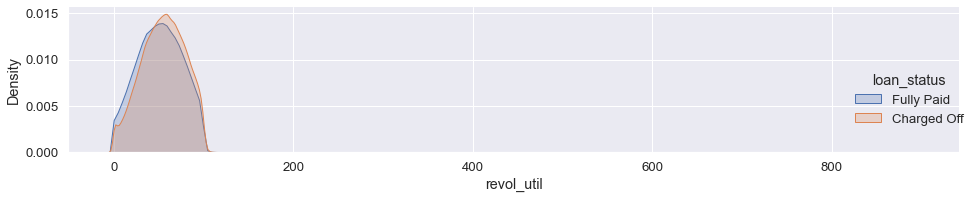

In [111]:
plot_var('revol_util', 'Revolving line utilization rate', continuous=True)

In [112]:
df.groupby('loan_status')['revol_util'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,268379.0,54.758433,23.865982,0.0,37.4,55.5,73.1,366.6
Fully Paid,1076074.0,51.074671,24.626821,0.0,32.5,51.3,70.1,892.3


Charged Off loans tend to have higher revol_util.

### total_acc
Data Dictionary: "The total number of credit lines currently in the borrower's credit file."

In [113]:
df['total_acc'].describe()

count    1.345310e+06
mean     2.498084e+01
std      1.199847e+01
min      2.000000e+00
25%      1.600000e+01
50%      2.300000e+01
75%      3.200000e+01
max      1.760000e+02
Name: total_acc, dtype: float64

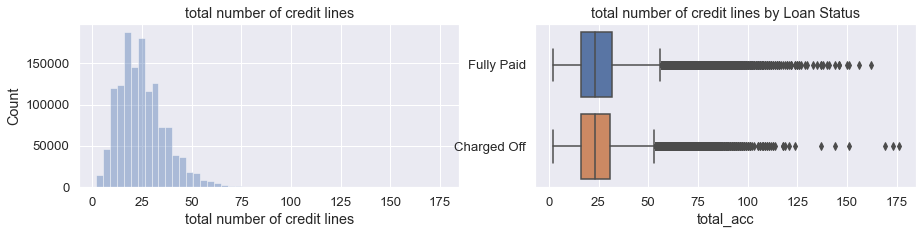

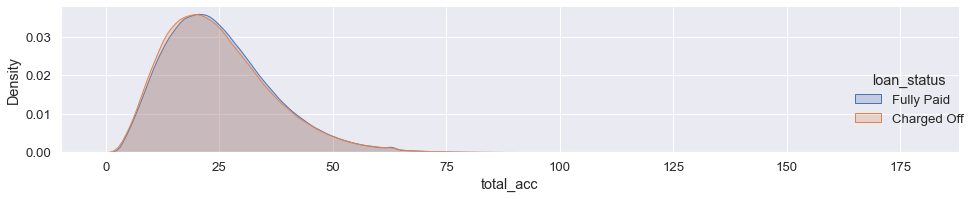

In [114]:
plot_var('total_acc', 'total number of credit lines', continuous=True)

### initial_list_status
Data Dictionary: "The initial listing status of the loan. Possible values are – W, F  (whole vs. fractional)

In [115]:
df['initial_list_status'].value_counts()

w    784010
f    561300
Name: initial_list_status, dtype: int64

Half of the granted loans are in whole amount and half are in fractional amount. "Whole" has higher fraction of Charged-Off.

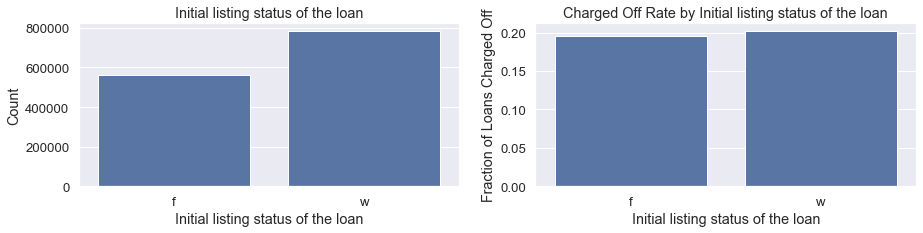

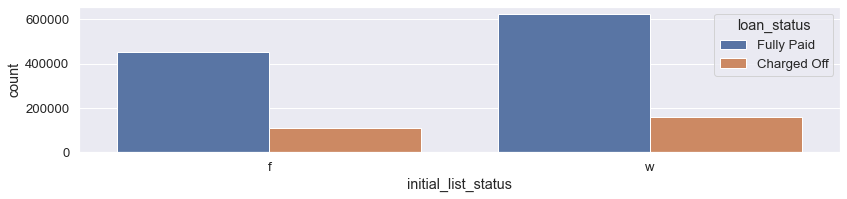

In [116]:
plot_var('initial_list_status','Initial listing status of the loan', continuous=False)

### policy_code
Data Dictionary: "publicly available policy_code=1; new products not publicly available policy_code=2"

In [117]:
df['policy_code'].value_counts()

1.0    1345310
Name: policy_code, dtype: int64

All values are the same; drop this feature. 

In [118]:
drop_cols('policy_code')

### application_type
Data Dictionary: "Indicates whether the loan is an individual application or a joint application with two co-borrowers."

In [119]:
df['application_type'].value_counts()

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

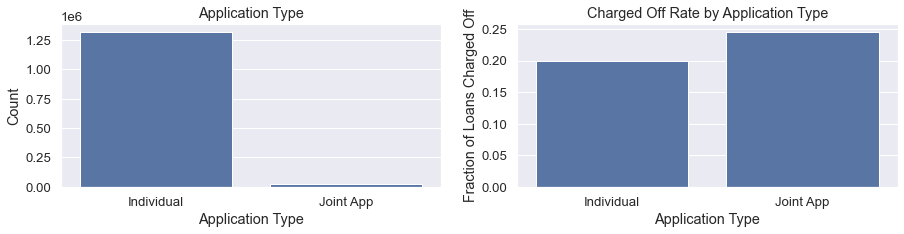

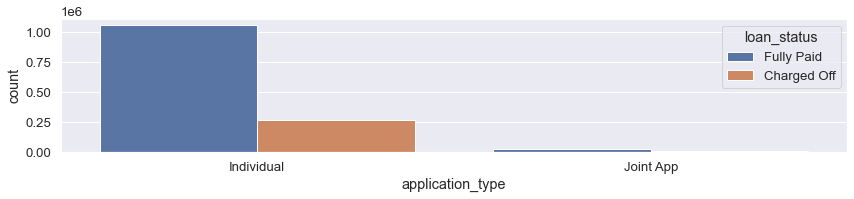

In [120]:
plot_var('application_type', 'Application Type', continuous=False)

The majority of the loans are individual applications and they are more possible to be charged off than joint app.

### mo_sin_old_il_acct
Data Dictionary: "Months since oldest bank installment account opened."

In [121]:
df['mo_sin_old_il_acct'].describe()

count    1.239735e+06
mean     1.257976e+02
std      5.223336e+01
min      0.000000e+00
25%      9.800000e+01
50%      1.290000e+02
75%      1.520000e+02
max      9.990000e+02
Name: mo_sin_old_il_acct, dtype: float64

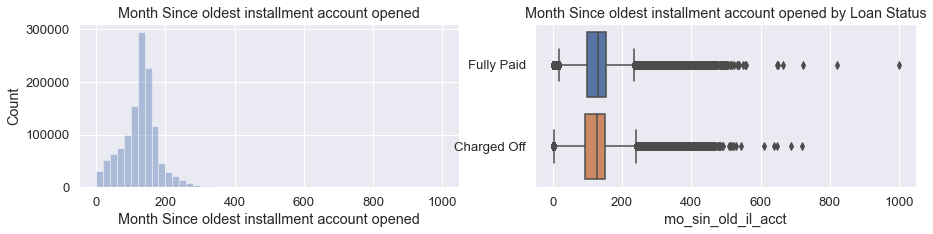

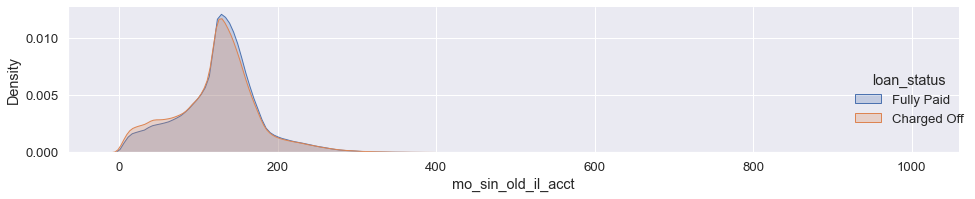

In [122]:
plot_var('mo_sin_old_il_acct', 'Month Since oldest installment account opened', continuous=True)

### mo_sin_old_rev_tl_op
Data Dictionary: "Months since oldest revolving account opened."

In [123]:
df['mo_sin_old_rev_tl_op'].describe()

count    1.277782e+06
mean     1.814760e+02
std      9.450512e+01
min      2.000000e+00
25%      1.170000e+02
50%      1.640000e+02
75%      2.300000e+02
max      8.520000e+02
Name: mo_sin_old_rev_tl_op, dtype: float64

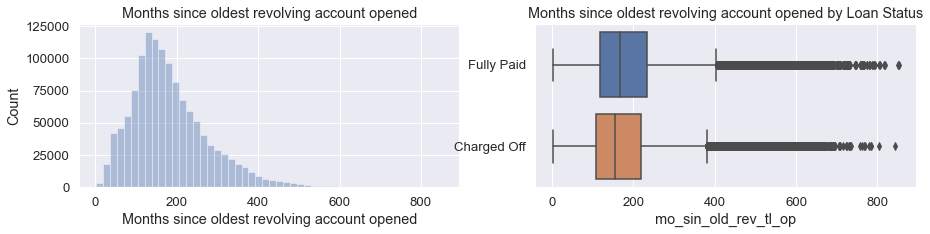

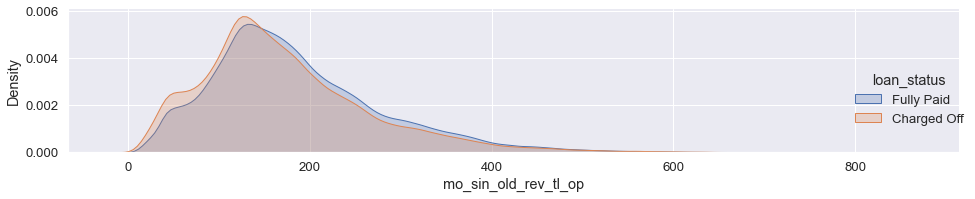

In [124]:
plot_var('mo_sin_old_rev_tl_op', 'Months since oldest revolving account opened', continuous=True)

### mort_acc
Data Dictionary: "Number of mortgage accounts."

In [125]:
df['mort_acc'].describe()

count    1.298029e+06
mean     1.670783e+00
std      2.000444e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      3.000000e+00
max      5.100000e+01
Name: mort_acc, dtype: float64

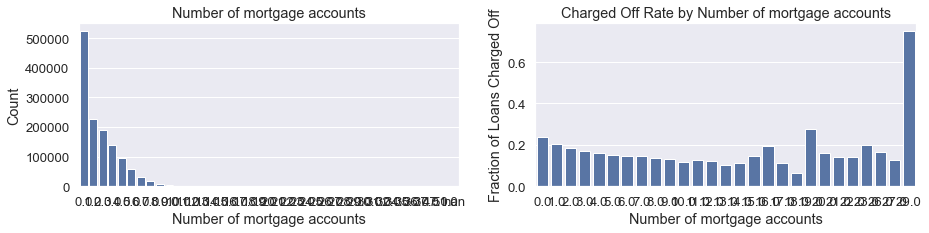

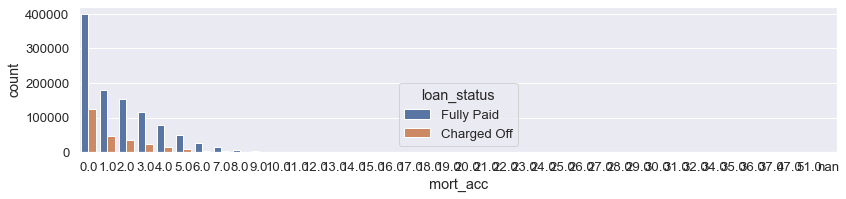

In [126]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

In [127]:
df.mort_acc = df.mort_acc.map(lambda x: 6.0 if x > 6.0 else x)

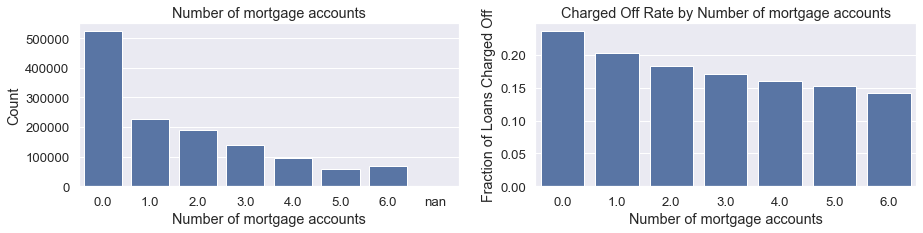

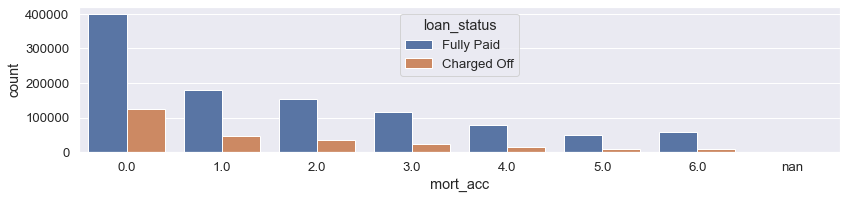

In [128]:
plot_var('mort_acc', 'Number of mortgage accounts', continuous=False)

The more the number of mortgage accounts, the lower fraction of loans charged off. 

In [129]:
df.groupby('loan_status')['mort_acc'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,261673.0,1.332598,1.683164,0.0,0.0,1.0,2.0,6.0
Fully Paid,1036356.0,1.683199,1.830426,0.0,0.0,1.0,3.0,6.0
